In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

定義遊戲棋盤類別

In [ ]:
class Playboard():
    def __init__(self, replace=False, boardSize=12):
        self.passList = []
        self.replace = replace
        self.boardSize = boardSize
        self.board = np.full(boardSize, -1, dtype=int)
        self.piecePlace = 0
        self.randomSeed = 0
        self.records = None

    def setBoard(self, entryList):
        self.board = np.array(entryList)

    def setRandomSeed(self, seed):
        np.random.seed(seed)

    def drawNumbers(self):
        nums = np.random.choice(10, 2, replace=self.replace)
        return nums

    def playOneGame(self):
        steps = np.sum(self.drawNumbers()) % 10
        if steps == 0: return True
        self.piecePlace = (self.piecePlace + steps) % self.boardSize
        number = self.board[self.piecePlace]
        while number in self.passList:
            self.piecePlace = (self.piecePlace + 1) % self.boardSize
            number = self.board[self.piecePlace]
        if number == -1: return True
        self.passList.insert(0, number)
        if len(self.passList) > 6:
            return False
        else: return True

    def gameReset(self):
        self.passList = []
        self.piecePlace = 0

    def storeResult(self, epoch):
        for num in self.passList:
            self.records[epoch, num] = self.records[epoch, num] + 1

    def getRecords(self):
        return self.records

    def run(self, batchSize=10, epochs=10):
        print('Simulation start...')
        self.records = np.zeros((epochs, 10))
        for ep in range(epochs):
            if ep%100 == 0: 
                print('epoch: {}'.format(ep))
            for i in range(batchSize):
                while self.playOneGame():
                    pass
                self.storeResult(ep)
                self.gameReset() 
  

設定棋盤內容、控制隨機種子並執行實驗

In [ ]:
game = Playboard()
game.setBoard([-1, 5, 9, 7, 1, 4, -1, 6, 0, 3, 8, 2])
game.setRandomSeed(79)
game.run(batchSize=1000, epochs=1000)
array = game.getRecords()

Simulation start...
epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900


檢視實驗數據及初步統計量

In [ ]:
statics = pd.DataFrame(array, columns=['0','1','2','3','4','5','6','7','8','9'], dtype=int)
statics.describe()

,0,1,2,3,4,5,6,7,8,9
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000
mean,701.202000,733.978000,683.177000,747.673000,732.001000,624.876000,624.1680,741.758000,711.682000,699.485000
std,14.432931,13.186485,15.449737,13.589877,14.752038,14.983295,15.7351,13.784464,14.851715,15.255901
min,658.000000,693.000000,635.000000,707.000000,687.000000,580.000000,573.0000,700.000000,667.000000,655.000000
25%,691.000000,724.000000,673.000000,738.000000,722.000000,615.000000,614.0000,732.000000,702.000000,689.000000
50%,701.000000,734.000000,683.000000,748.000000,732.000000,625.000000,624.0000,742.000000,712.000000,699.000000
75%,710.000000,743.000000,694.000000,757.000000,742.000000,635.000000,635.0000,751.250000,722.000000,710.250000
max,742.000000,785.000000,736.000000,784.000000,778.000000,671.000000,675.0000,781.000000,758.000000,745.000000


儲存實驗數據成CSV檔

In [ ]:
statics.to_csv('raw_data.csv')

畫出數據的平均與標準差

<BarContainer object of 10 artists>

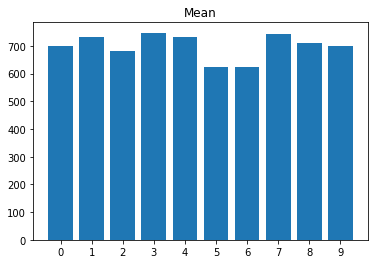

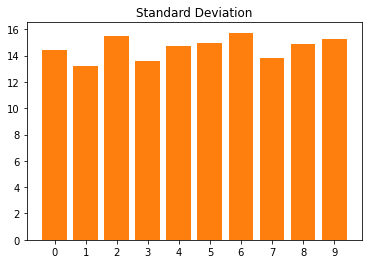

In [ ]:
plt.figure(0)
plt.title('Mean')
plt.bar(statics.columns.values, statics.mean())
plt.figure(1)
plt.title('Standard Deviation')
plt.bar(statics.columns.values, statics.std(), color='tab:orange')

觀察每個號碼的分布狀態，初步猜測所有號碼在抽樣中皆為常態分布

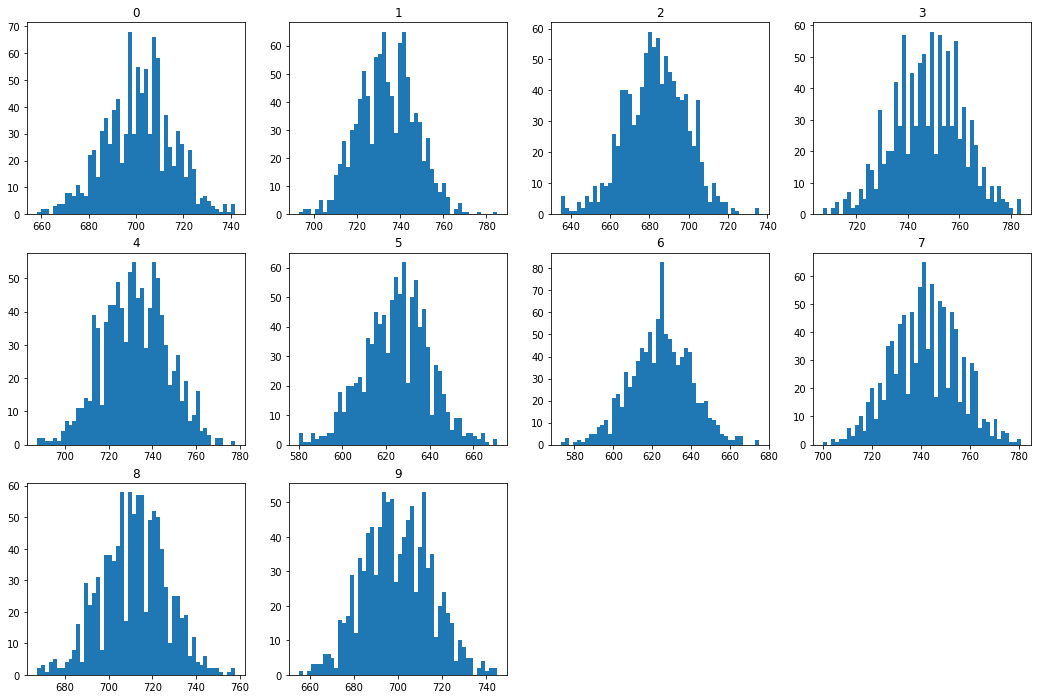

In [ ]:
import scipy.stats as stats
fig = plt.figure(figsize=(18, 12))
for i in statics.columns.values:
  ax = fig.add_subplot(3, 4, np.int(i)+1)
  ax.set_title(i)
  x = statics[i]
  ax.hist(x, bins=50);

因猜測為常態分布，故將每個號碼依其平均與標準差繪製出機率密度函數(PDF)，發現號碼5、6的出現次數較低且離群

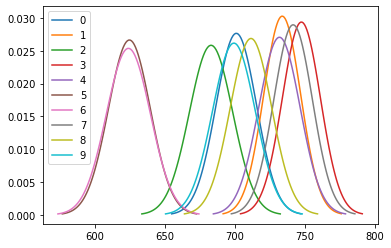

In [ ]:
from scipy.stats import norm

for i in statics.columns.values:
  mu = np.mean(statics[i])
  sigma = np.std(statics[i])
  x = np.linspace(mu-3.2*sigma, mu+3.2*sigma, 100)
  plt.plot(x, norm.pdf(x, mu, sigma))
plt.legend(statics.columns.values)

對所有號碼分布進行Chi-squared檢定